In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import sys
sys.path.append('../code/')
from TracyWidom import TracyWidom

In [2]:
def cutoff_index(arr,cutoff):
    max_cutoff = len(arr)
    if np.all(np.invert(np.isfinite(arr))):
        return np.nan
    arr = arr[np.isfinite(arr)]
    for i in range(len(arr)):
        if np.all(arr[i:]>cutoff):
            return i
    return max_cutoff-1

def compute_threshold_array(KL_df,cutoff,p):
    m_list = np.sort(np.unique(KL_df.m.values))[::-1] ## Flipping the m_list to start from larger to smaller
    n_list = np.sort(np.unique(KL_df.n.values))
    m_threshold_list = [] ## a list of size equal to n_list, where each entry is the m threshold for a corresponding n
    n_threshold_list = [] ## a list of size equal to m_list, where each entry is the n threshold for a corresponding m

    for n in n_list:
        temp_arr = KL_df[KL_df.n == n].sort_values("m").loc[:,"p_%d"%p].values[::-1]
        m_threshold_list.append(m_list[cutoff_index(temp_arr,cutoff)])

    for m in m_list:
        temp_arr = KL_df[KL_df.m == m].sort_values("n").loc[:,"p_%d"%p].values
        n_threshold_list.append(n_list[cutoff_index(temp_arr,cutoff)])

    return m_threshold_list,n_threshold_list

tw = TracyWidom(beta=1)
def TWp(eigenvalue,n,L,r):
    # l: The raw eigenvalue
    # n: the number of individuals sampled
    # L: the number of SNPs sampled
    # r: the rank of the eigenvalue (pth largest eigenvalue)
    # K: num_demes
    if n>L:
        return np.nan

    try:
        n=n-1-r ##actual sample size is n-1
        gamma = n/L
        mean = (1+np.sqrt(gamma))**2
        std = ((1+np.sqrt(gamma))**(4/3))*gamma**(-1/6)
        l = (eigenvalue-mean)/std
        p = 1-tw.cdf(l)
        return p
    except:
        return np.nan


In [3]:
N=500
path = "../data/eigen_analysis/1d_SS/"
folders = os.listdir(path)
m_folders = np.array(os.listdir(path+folders[0]))
K_list = []
m_list = []

for i,folder in enumerate(folders):
    K = float(folder.split("=")[1])
    K_list.append(K)
folders = np.array(folders)

for i,folder in enumerate(m_folders):
    m = float(folder.split("=")[1])
    m_list.append(m)
folders = np.array(folders)
m_list = np.array(m_list)

m_order = np.argsort(m_list)
m_ordered = np.sort(m_list)

n_list = np.arange(2,101,2)
L_list = np.geomspace(50,4000,50).astype(int)

Detecting unfinished simulations for convenience of downstream analysis

In [4]:
unfinished_sims = {5:[],7:[],9:[],11:[]}
for K in K_list:
    for folder in m_folders:
        file_path = path+"K=%d/"%K+folder+"/eigenvalues.csv"
        if not os.path.exists(file_path):
            unfinished_sims[K].append(float(folder.split("=")[1]))

finished_m_dict = {K: np.array([m for m in m_list if m not in unfinished_sims[K]]) for K in K_list}


### Combining data in different folders into a single dataframe


In [5]:
column_names =["K","m"]+list(pd.read_csv(path+folders[0]+"/"+m_folders[0]+"/eigenvalues.csv",index_col=0).columns)
full_df = pd.DataFrame(columns = column_names)
unfinished_sims_total = []
for K in K_list:
    for i,folder in enumerate(m_folders[m_order]):
        try:
            temp_df = pd.read_csv(path+"K=%d/"%K+folder+"/eigenvalues.csv",index_col=0)
            m = m_ordered[i]
            temp_df['m'] = [m]*len(temp_df.index) ## Adding columns to the eigenvalue df of a specific m and K
            temp_df['K'] = [K]*len(temp_df.index)
            temp_df = temp_df[["K","m"]+list(temp_df.columns[:-2])] # Rearranging the columns
            full_df = pd.concat([full_df,temp_df])
        except: 
            continue
    unfinished_sims_total.append(unfinished_sims)
full_df.replace(np.inf,16,inplace=True) ## very small p-values will have a -log10(p) set to 10

full_df.K = full_df.K.astype(int)
full_df.n = full_df.n.astype(int)
full_df.L= full_df.L.astype(int)


full_df["nL"] = full_df.n * full_df.L
full_df["-log(m)"] = -np.log10(full_df.m)
full_df.to_csv("../data/full_data/1d.csv")

In [6]:
# for index, row in full_df.iterrows():
#     n = row["n"]
#     L = row["L"]
#     l_1 = row["l_1"]
#     l_2 = row["l_2"]

#     full_df.at[index, "p_1"] = TWp(l_1, n=n, L=L, r=1)
#     full_df.at[index, "p_2"] = TWp(l_2, n=n, L=L, r=2)

Text(0, 0.5, '-log10(p)')

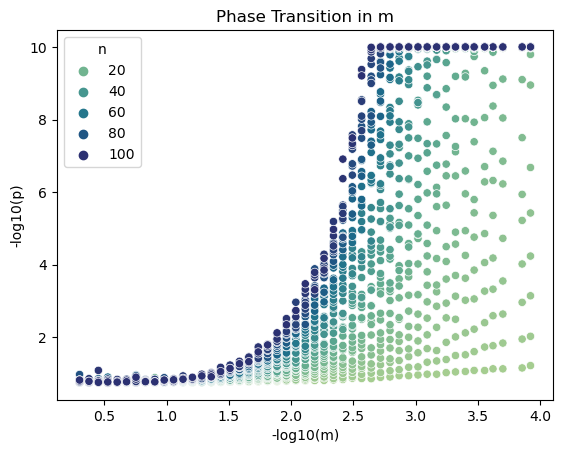

In [7]:
K=5
L = L_list[30]
K_df = full_df[full_df.K == K]
KL_df = K_df[K_df.L == L]
sns.scatterplot(KL_df,x = '-log(m)',y='p_1',hue='n',palette = 'crest')
plt.title("Phase Transition in m")
plt.xlabel("-log10(m)")
plt.ylabel("-log10(p)")

Text(0, 0.5, '-log10(p)')

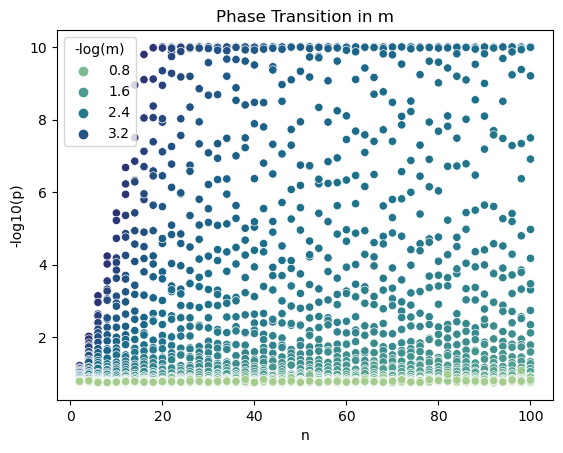

In [8]:
sns.scatterplot(KL_df,x = 'n',y='p_1',hue='-log(m)',palette = 'crest')
plt.title("Phase Transition in m")
plt.xlabel("n")
plt.ylabel("-log10(p)")

### A different L value

Text(0, 0.5, '-log10(p)')

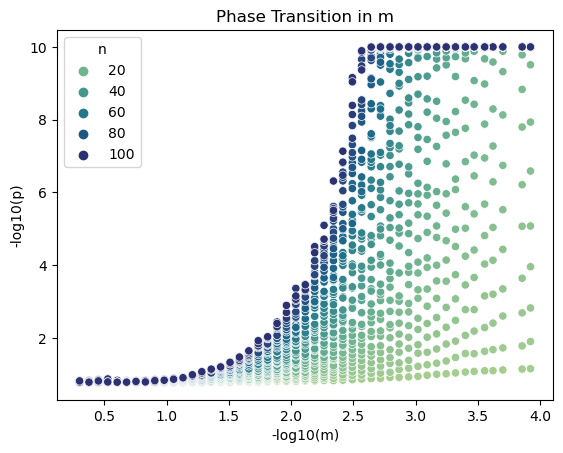

In [9]:
K=5
L = L_list[40]
K_df = full_df[full_df.K == K]
KL_df = K_df[K_df.L == L]
sns.scatterplot(KL_df,x = '-log(m)',y='p_1',hue='n',palette = 'crest')
plt.title("Phase Transition in m")
plt.xlabel("-log10(m)")
plt.ylabel("-log10(p)")

### m value beyond which structure starts being detected

In [10]:
cutoff = 0.5
K=5
L = L_list[40]
K_df = full_df[full_df.K == K]
KL_df = K_df[K_df.L == L]

m_threshold_list,n_threshold_list = compute_threshold_array(KL_df,cutoff=0.85,p=1)

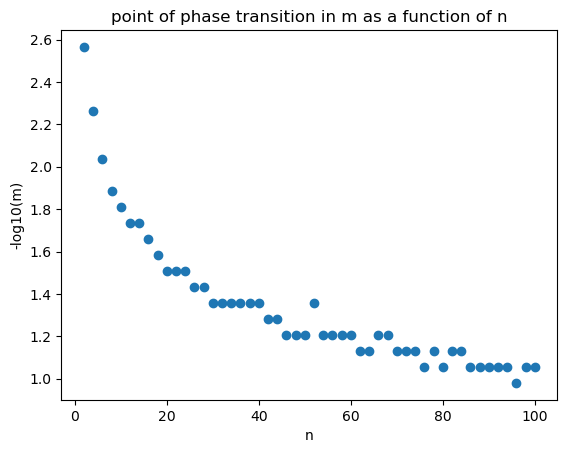

In [11]:
x_values = n_list
y_values = -np.log10(m_threshold_list)

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points')
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('n')
plt.ylabel('-log10(m)')
plt.title("point of phase transition in m as a function of n")
# plt.legend()
# plt.grid(True)
plt.show()

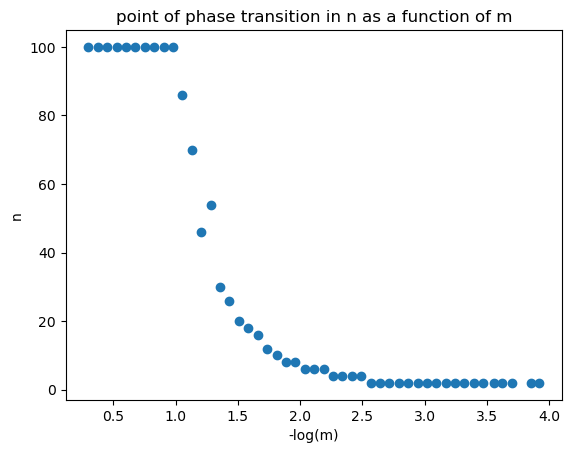

In [12]:
x_values = -np.log10(np.sort(finished_m_dict[5]))[::-1]
y_values = n_threshold_list

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points')
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('-log(m)')
plt.ylabel('n')
plt.title("point of phase transition in n as a function of m")
# plt.legend()
# plt.grid(True)
plt.show()

# Eigenvectors

## PC plots

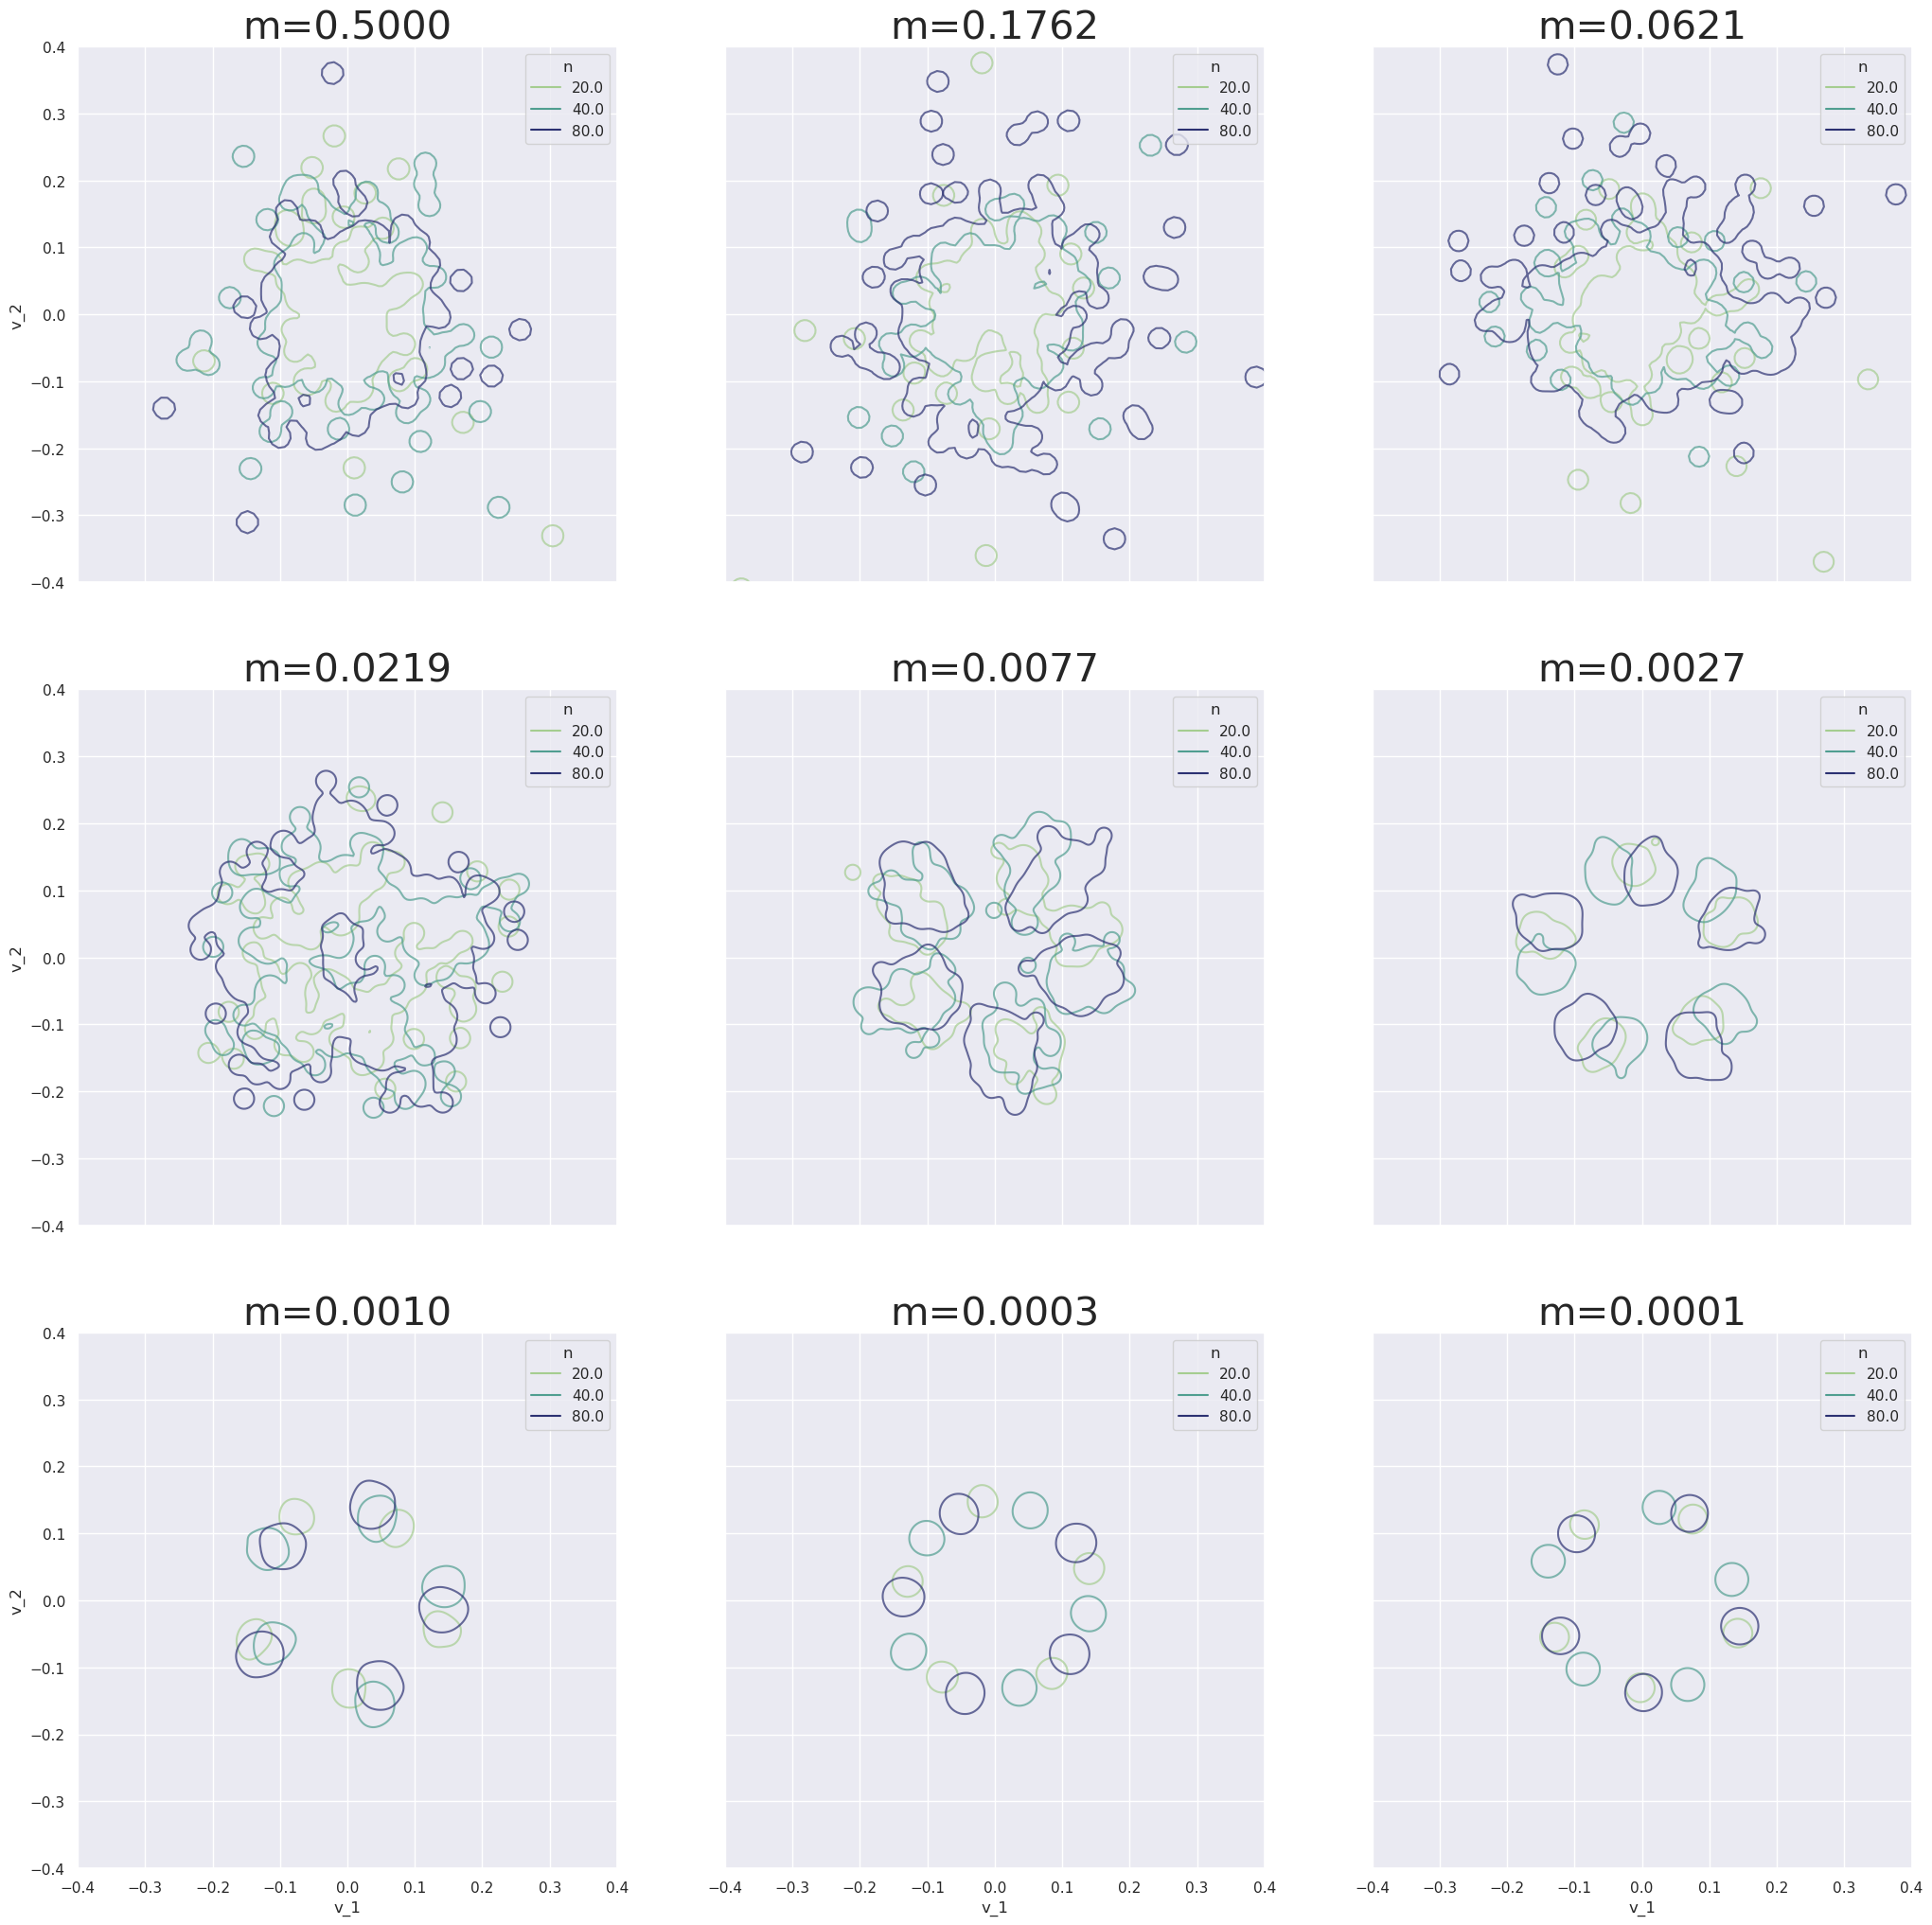

In [18]:
K=5
n_subset = [20,40,80]
max_n = np.max(n_subset)
m_subset = np.sort(finished_m_dict[5])[np.linspace(0,len(finished_m_dict[5])-1,9).astype(int)][::-1]
L = L_list[30]

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3,3,figsize=(25, 25),sharex= True,sharey = True)

for i,m in enumerate(m_subset):
    path = ("../data/eigen_analysis/1d_SS/K=%d/m=%.5f"%(K,m)).rstrip("0")
    eigenvector_df = pd.read_csv(path+"/eigenvectors.csv",index_col=0)
    data_subset  = eigenvector_df.query("n in @n_subset")
    data_subset = data_subset[data_subset.L == L]
    data_subset.v_1 = data_subset.v_1 * np.sqrt(data_subset.n/min(n_subset))
    data_subset.v_2 = data_subset.v_2 * np.sqrt(data_subset.n/min(n_subset))
    temp_ax = ax[i//3,i%3]
    g = sns.kdeplot(
        data=data_subset,
        x="v_1",
        y="v_2",
        hue="n",
        levels = 1,
        bw_method = 0.1,
        ax = temp_ax,
        palette = "crest",
        alpha=0.7
        )

    temp_ax.set_xlim([-0.4,0.4])
    temp_ax.set_ylim([-0.4,0.4])
    temp_ax.set_title("m=%.4f"%m,fontsize = "30")
# handles, labels = ax[-1,-1].get_legend_handles_labels()
# fig.legend(handles, labels,loc = "right",fontsize='xx-large')
#sns.move_legend(g, "center right", bbox_to_anchor=(.55, 1.05))
# fig.supxlabel("PC1",fontsize=24)
# fig.supylabel("PC2",fontsize=24)
# fig.suptitle('PCA density for 1d Stepping Stones Model, K=%d'%K, fontsize=24)


### Inconsistency

In [14]:
def rotate_vectors(K,empirical_vectors):
    x,y = empirical_vectors.shape
    n = int(x/K) ## The number of samples from each deme
    v1_theor = np.cos([(2*i*np.pi)/K for i in range(K)])
    v2_theor = np.sin([(2*i*np.pi)/K for i in range(K)])
    v1_theor = v1_theor/np.linalg.norm(v1_theor)
    v2_theor = v2_theor/np.linalg.norm(v2_theor)

    v1_cent = [np.mean(empirical_vectors[i*n:(i+1)*n,0]) for i in range(K)]
    v2_cent = [np.mean(empirical_vectors[i*n:(i+1)*n,1]) for i in range(K)]
    v1_cent = v1_cent/np.linalg.norm(v1_cent)
    v2_cent = v2_cent/np.linalg.norm(v2_cent)

    theta = []
    for i in range(K):
        theta.append(np.arccos(np.dot([v1_theor[0],v2_theor[0]],[v1_cent[i],v2_cent[i]])))
    min_theta = np.min(theta)/2
    min_theta_inx = np.argmin(theta)

    y = v2_cent[min_theta_inx]
    if y>0:   
        R = np.array([[np.cos(min_theta),np.sin(min_theta)],
                [-np.sin(min_theta),np.cos(min_theta)]])
    else:
        R = np.array([[np.cos(min_theta),-np.sin(min_theta)],
                    [np.sin(min_theta),np.cos(min_theta)]])

    modified_vectors = np.matmul(R,empirical_vectors.T).T

    return modified_vectors

def eigen_inconsistency(K,rotated_vectors):
    demes_order = [] ## the ith value of this vector means that deme k should lie in cos(2*pi*i/K), or sine
    remaining_indices = list(range(K))
    x,y = rotated_vectors.shape
    n = int(x/K) ## The number of samples from each deme
    for k in range(K):
        rotated_vectors_subset = rotated_vectors[n*k:(k+1)*n,:] ## The subset of PCs corresponding to samples from deme k
        v1_subset = rotated_vectors_subset[:,0]
        v2_subset = rotated_vectors_subset[:,1]

        v_emp_centroid = np.array([np.mean(v1_subset),np.mean(v2_subset)])
        v_emp_centroid = v_emp_centroid/np.linalg.norm(v_emp_centroid)

        ## This methodology allows me to look for the index in the theoretical eigenvectors that corresponds to deme k
        ## It then allows me to match each eigenvector with the right theoretical one. SInce I have 2 eigenvectors, they can come flipped from PCA, so I have to account for that
        vector_of_angles = []
        for i in remaining_indices:
            v_theor_centroid = np.array([np.cos(2*np.pi*i/K),np.sin(2*np.pi*i/K)])
            v_theor_centroid = v_theor_centroid/np.linalg.norm(v_theor_centroid)
            vector_of_angles.append(np.arccos(np.dot(v_theor_centroid,v_emp_centroid)))

        min_index = np.argmin(np.abs(vector_of_angles))
        demes_order.append(remaining_indices[min_index])
        remaining_indices.remove(remaining_indices[min_index])

    ordered_cos_vector = np.repeat([np.cos(2*np.pi*i/K) for i in demes_order],n)
    ordered_sine_vector = np.repeat([np.sin(2*np.pi*i/K) for i in demes_order],n)

    # ordered_cos_vector = np.repeat([np.cos(2*np.pi*i/K) for i in range(5)],n)
    # ordered_sine_vector = np.repeat([np.sin(2*np.pi*i/K) for i in range(5)],n)

    v1_emp = rotated_vectors[:,0]/np.linalg.norm(rotated_vectors[:,0])
    v2_emp = rotated_vectors[:,1]/np.linalg.norm(rotated_vectors[:,1])

    v1_theor = ordered_cos_vector/np.linalg.norm(ordered_cos_vector)
    v2_theor = ordered_sine_vector/np.linalg.norm(ordered_sine_vector)

    angle_with_cos_vector = np.arccos(np.dot(v1_emp,v1_theor))
    angle_with_sine_vector = np.arccos(np.dot(v1_emp,v2_theor))

    if angle_with_cos_vector<angle_with_sine_vector:
        v1_inconsistency = angle_with_cos_vector
        v2_inconsistency = np.arccos(np.dot(v2_emp,v2_theor))
    else:
        v1_inconsistency = angle_with_sine_vector
        v2_inconsistency = np.arccos(np.dot(v2_emp,v1_theor))
    
    return v1_inconsistency,v2_inconsistency


def create_inconsistency_df(K):
    ## Create an dataframe with 4 columns: [m, n(or L), v1_inconsistency,v2_inconsistency]
    ## Either n is fixed and L is varied, or the opposite
    ## The value of the fixed parameter is inputted as n_or_L

    inconsistency_df = pd.DataFrame(columns=["m","n","L","theta_1","theta_2"])

    for m in np.sort(finished_m_dict[K]):
        path = ("../data/eigen_analysis/1d_SS/K=%d/m=%.5f"%(K,m)).rstrip("0")
        eigenvector_df = pd.read_csv(path+"/eigenvectors.csv",index_col=0)
        for n in n_list:
            subset = eigenvector_df[eigenvector_df.n == n]
            for L in L_list:
                subset2 = subset[subset.L == L]
                v1 = subset2.v_1.values
                v2 = subset2.v_2.values
                if len(v1)!=0 and len(v2)!=0:
                    vectors = np.hstack((v1.reshape(-1,1),v2.reshape(-1,1)))
                    rotated_vectors = rotate_vectors(K,vectors)
                    v1_inconsistency,v2_inconsistency = eigen_inconsistency(K,rotated_vectors)
                    new_row = [m,n,L,v1_inconsistency,v2_inconsistency]
                    inconsistency_df.loc[len(inconsistency_df)] = new_row
                else:
                    continue
    return inconsistency_df

In [15]:
inconsistency_df = create_inconsistency_df(K)

In [16]:
L = L_list[30]
inconsistency_df_subset = inconsistency_df[inconsistency_df.L == L]
inconsistency_df_subset = inconsistency_df_subset.iloc[:,[0,1,3]]
inconsistency_df_subset = inconsistency_df_subset.pivot(index = "m",columns="n",values = "theta_1")

<AxesSubplot: xlabel='n', ylabel='m'>

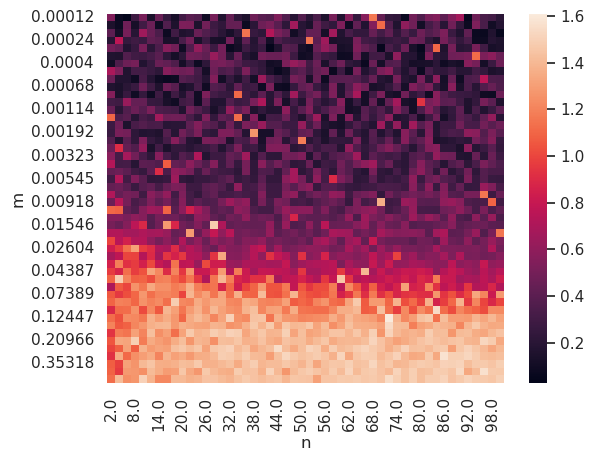

In [17]:
sns.heatmap(inconsistency_df_subset)